In [5]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# Import Data

In [6]:
np.random.seed(7)

In [7]:
data = pd.read_csv('https://raw.githubusercontent.com/Mluthfialgifari/Tugas-Akhir-Skripsi/refs/heads/main/Data/Data%20TMA%20(Daily%202022-2025).csv')
data = data.loc[:, ['Daily_Period','TMA_Daily']]
data = data.iloc[:1216].reset_index(drop=True)

print(data.head())
print(data.tail())
print(data.shape)

  Daily_Period  TMA_Daily
0   01/01/2022       10.0
1   02/01/2022       10.0
2   03/01/2022       10.0
3   04/01/2022       10.0
4   05/01/2022       12.5
     Daily_Period  TMA_Daily
1211   26/04/2025  20.000000
1212   27/04/2025  20.000000
1213   28/04/2025  21.666667
1214   29/04/2025  20.000000
1215   30/04/2025  14.166667
(1216, 2)


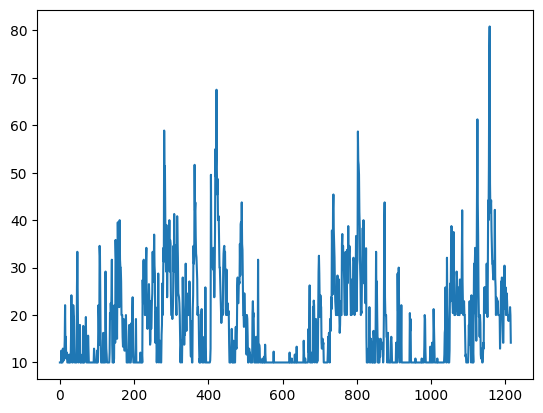

In [8]:
plt.plot(data['TMA_Daily'])

# Normalisasi Data

Proses normalisasi data dilakukan menggunakan metode min-max normalization hingga menghasilkan data yang berskala [0,1].

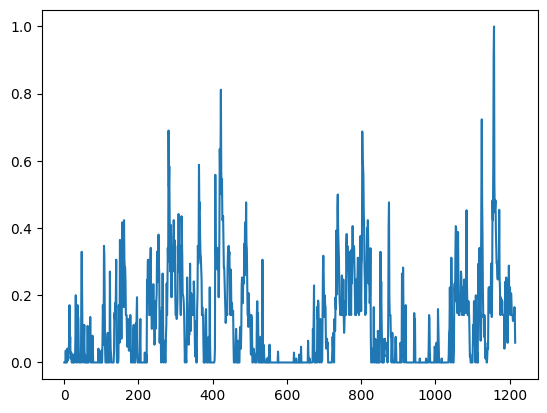

In [9]:
# Step 1: Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['TMA_normalized'] = scaler.fit_transform(data['TMA_Daily'].values.reshape(-1, 1))
plt.plot(data['TMA_normalized'])

# Hyperparameter Tuning & Cross Validation

Hyperparameter tuning dilakukan untuk menentukan hyperparameter terbaik melalui langkah validasi berupa *time series k-fold cross validation*. Banyaknya fold yang digunakan dalam langkah validasi adalah sebanyak k = 5.

EXPANDING WINDOW

In [10]:
data_series = data['TMA_normalized'].values
data_series = data_series.reshape((len(data_series), 1))
data_series

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.16470588],
       [0.14117647],
       [0.05882353]])

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def create_model(neurons, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(30, 1), return_sequences=True))
    model.add(LSTM(16))
    model.add(Dropout(0.01))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [12]:
import keras

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # print('abcd')
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

## Sliding Window Cross Validation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0101 - val_loss: 0.0216
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - val_loss: 0.0290
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.0097
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0140
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0205
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0106
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0138
Epoch 8/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0120
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 21.653867962058275 %
mape test = 22.793560706937228 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0326 - val_loss: 0.0331
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0243 - val_loss: 0.0262
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0192
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109 - val_loss: 0.0302
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - val_loss: 0.0246
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - val_loss: 0.0224
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0128 - val_loss: 0.0215
Epoch 8/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - val_loss: 0.0205
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 38.824037128899185 %
mape test = 51.97144001379631 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0020 - val_loss: 8.2341e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 8.2811e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 1.5415e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 3.9269e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 1.9304e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 4.2945e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 1.5734e-04
Epoch 9/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 2.7939e-04
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0342 - val_loss: 0.0038
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0172 - val_loss: 0.0116
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0139 - val_loss: 0.0062
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - val_loss: 0.0036
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0122 - val_loss: 0.0094
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 10/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - val_loss: 0.0071
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0130 - val_loss: 0.0195
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - val_loss: 0.0147
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0108
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0064 - val_loss: 0.0146
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0055 - val_loss: 0.0141
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0126
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0102
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0115
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0145
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0115
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0133
Epoch 12/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055Restoring model w

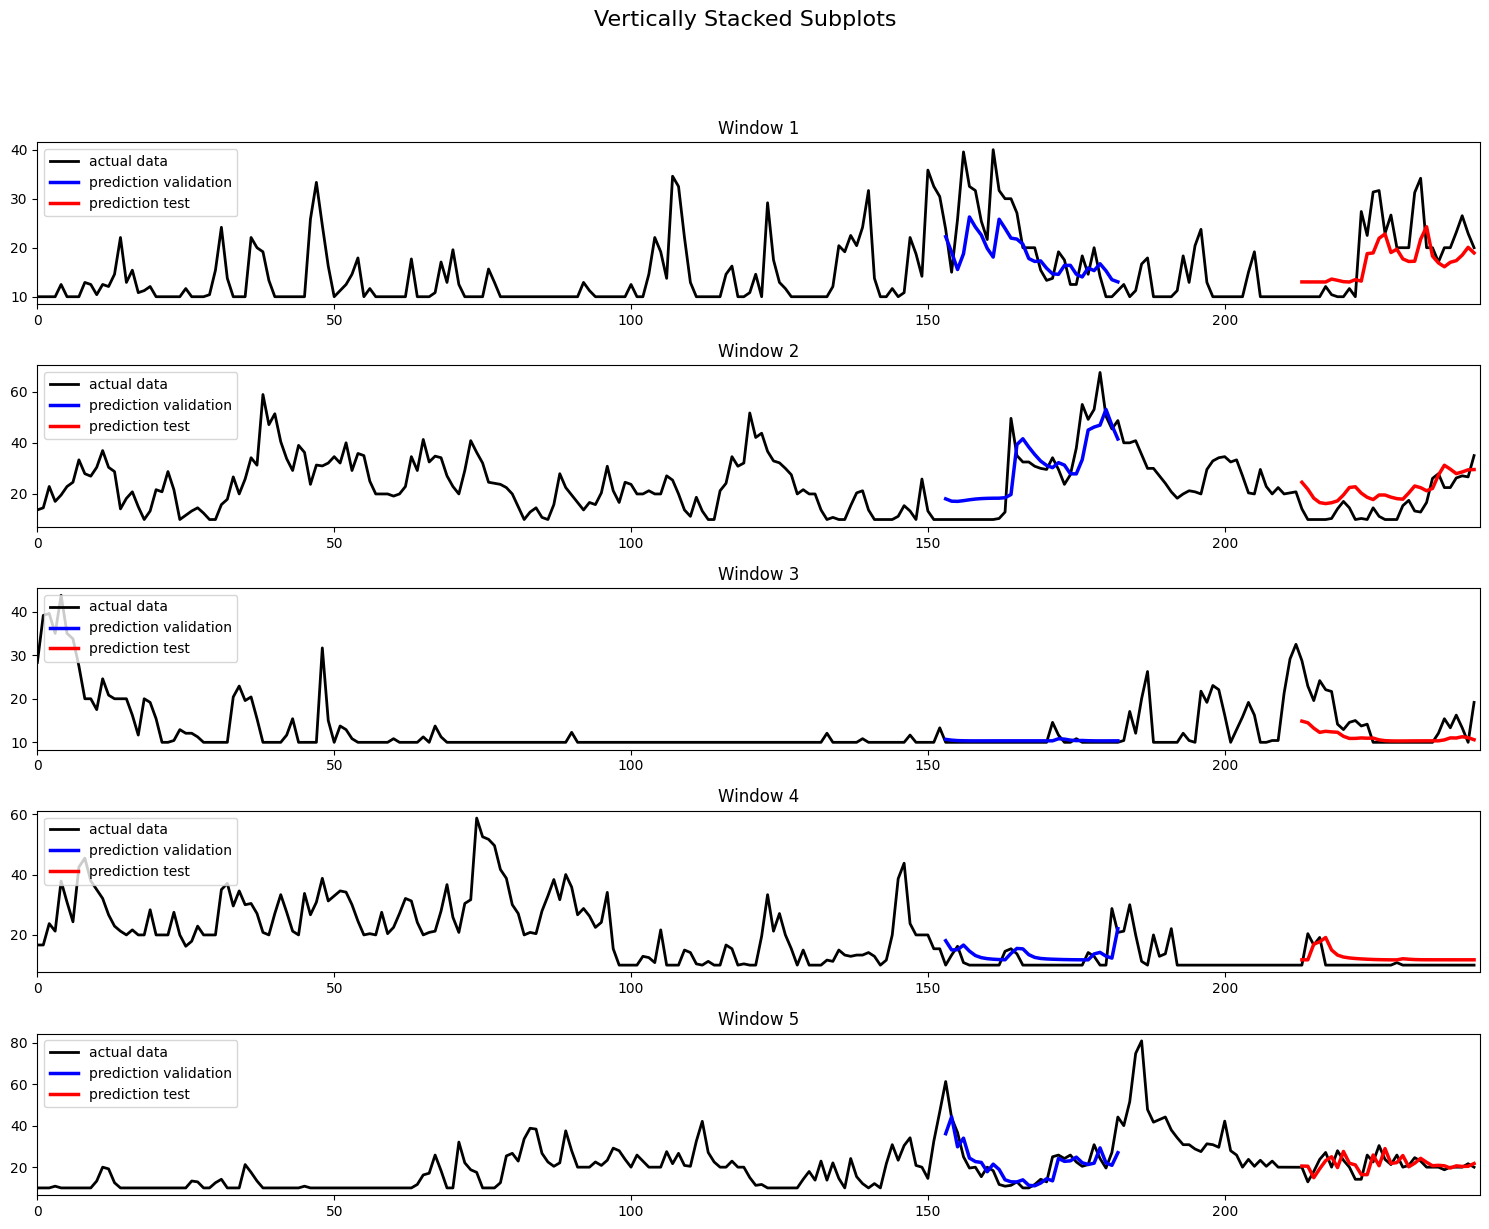


Final Average MAPE Validation: 0.2233
Final Average MAPE Test: 0.2653
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0134 - val_loss: 0.0223
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0047 - val_loss: 0.0235
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0054 - val_loss: 0.0324
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0053 - val_loss: 0.0195
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0179
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 0.0122
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - val_loss: 0.0175
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0159
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0103
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.0160
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0034 - val_loss: 0.0158
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0229 - val_loss: 0.0478
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0196 - val_loss: 0.0174
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0264
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0133 - val_loss: 0.0201
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0231
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0117 - val_loss: 0.0203
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0077 - val_loss: 0.0192
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 31.376347397597034 %
mape test = 41.01060146786841 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0019 - val_loss: 2.2744e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 1.5031e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 8.4443e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 2.9925e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 5.0762e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 1.4504e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 2.0495e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 3.6538e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0020 - val_loss: 3.6488e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - val_loss: 1.4536e-04
Epoch 11/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025Restoring model weights from the end of the best epoch.
93/93 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0355 - val_loss: 0.0060
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130 - val_loss: 0.0032
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0036
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0084 - val_loss: 0.0095
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0127 - val_loss: 0.0053
Epoch 7/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.500685919818718 %
mape test = 12.002750929384183 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0118 - val_loss: 0.0306
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0122 - val_loss: 0.0187
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0155
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0119
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0138
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - val_loss: 0.0120
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0061 - val_loss: 0.0108
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0139
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0113
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0123
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2001
Final Average MAPE Test: 0.2393
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0096 - val_loss: 0.0180
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0255
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - val_loss: 0.0248
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0167
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0294
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0065 - val_loss: 0.0217
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0163
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0134
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0234
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - val_loss: 0.0116
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0153
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0779 - val_loss: 0.0416
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0201 - val_loss: 0.0310
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0151 - val_loss: 0.0321
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0106 - val_loss: 0.0253
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - val_loss: 0.0190
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0195
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0269
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0207
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0175
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0181
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0237
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0028 - val_loss: 3.3546e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 1.6353e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 2.6920e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0045 - val_loss: 1.9022e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 2.2224e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 1.5873e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 3.2630e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 3.8745e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 1.6863e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 4.1642e-04
Epoch 12/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0302 - val_loss: 0.0081
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0141 - val_loss: 0.0061
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0100 - val_loss: 0.0044
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - val_loss: 0.0087
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0034
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0039
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0040
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - val_loss: 0.0049
Epoch 10/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0107 - val_loss: 0.0197
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - val_loss: 0.0169
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - val_loss: 0.0125
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0160
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0107
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0169
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0121
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0139
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0191
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - val_loss: 0.0149
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0042 - val_loss: 0.014

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1616
Final Average MAPE Test: 0.1966
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0123 - val_loss: 0.0281
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0242
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0193
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0137
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0186
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0050 - val_loss: 0.0212
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 0.0192
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0141
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0122
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0132
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0215
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0225 - val_loss: 0.0531
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0144 - val_loss: 0.0185
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120 - val_loss: 0.0243
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - val_loss: 0.0235
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0117 - val_loss: 0.0208
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0203
Epoch 7/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - val_loss: 0.0236
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 31.471700216772717 %
mape test = 38.82125038354008 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0051 - val_loss: 1.8581e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 1.5320e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 2.2955e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 2.1565e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 1.5719e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 2.6038e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 3.244423924304841 %
mape test = 19.788525141580568 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0207 - val_loss: 0.0460
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0140 - val_loss: 0.0042
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0044
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.0043
Epoch 7/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - val_loss: 0.0072
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 32.959303846638136 %
mape test = 34.246555951763774 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0132 - val_loss: 0.0207
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0090 - val_loss: 0.0177
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0107 - val_loss: 0.0125
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0150
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0176
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0100
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0140
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0157
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - val_loss: 0.0148
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0198
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2173
Final Average MAPE Test: 0.2627
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0947 - val_loss: 0.0412
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0140
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0140
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - val_loss: 0.0153
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 0.0254
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - val_loss: 0.0175
Epoch 7/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0079 - val_loss: 0.0241
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
mape validation = 39.95610403571259 %
mape test = 47.514582609336315 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1539 - val_loss: 0.0580
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0284 - val_loss: 0.0588
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0242 - val_loss: 0.0743
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0332 - val_loss: 0.0960
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0276 - val_loss: 0.0706
Epoch 6/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0385Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0380 - val_loss: 0.0837
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 83.61173367069962 %
mape test = 112.12832813718316 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1038 - val_loss: 3.2836e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0062 - val_loss: 1.6122e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 8.2958e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 2.8744e-04
Epoch 7/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011    Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 4.3740e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 2.5988639838891374 %
mape test = 20.826121207085393 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0560 - val_loss: 0.0487
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0261 - val_loss: 0.0160
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0325 - val_loss: 0.0336
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0292 - val_loss: 0.0466
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0337 - val_loss: 0.0624
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0293 - val_loss: 0.0228
Epoch 7/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0309Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0306 - val_loss: 0.0493
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 80.37161164496307 %
mape test = 90.7583766746314 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0452 - val_loss: 0.0262
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0167 - val_loss: 0.0289
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0133 - val_loss: 0.0298
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0097 - val_loss: 0.0569
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0172 - val_loss: 0.0379
Epoch 6/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124 - val_loss: 0.0327
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 40.76341882779012 %
mape test = 15.071006879375485 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.4946
Final Average MAPE Test: 0.5726
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0328 - val_loss: 0.0256
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0163
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0358
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.0276
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.0280
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0074 - val_loss: 0.0206
Epoch 7/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0071 - val_loss: 0.0228
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 32.03129856609257 %
mape test = 39.17049808102867 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0591 - val_loss: 0.0677
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0449 - val_loss: 0.0662
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0477 - val_loss: 0.0586
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0292 - val_loss: 0.0631
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0333 - val_loss: 0.0765
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0249 - val_loss: 0.0618
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0232 - val_loss: 0.0580
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0257 - val_loss: 0.0772
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0229 - val_loss: 0.0588
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0317 - val_loss: 0.0612
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0231 - val_loss: 0.0698
Epoch 12/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281Restoring model w

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0222 - val_loss: 1.6306e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 5.2793e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033 - val_loss: 2.5930e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0047 - val_loss: 3.1257e-04
Epoch 6/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0052 - val_loss: 2.0824e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 1.8239260663504917 %
mape test = 23.336524482988143 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1337 - val_loss: 0.0190
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0225 - val_loss: 0.0034
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0440 - val_loss: 0.0049
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0437 - val_loss: 0.0502
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0467 - val_loss: 0.0147
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0249 - val_loss: 0.0194
Epoch 7/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0384 - val_loss: 0.0248
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 25.957916200794923 %
mape test = 29.833934532359326 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1016 - val_loss: 0.0411
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0179 - val_loss: 0.0302
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0165 - val_loss: 0.0297
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0147 - val_loss: 0.0283
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0188 - val_loss: 0.0349
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0144 - val_loss: 0.0339
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0199 - val_loss: 0.0280
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0417
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0126 - val_loss: 0.0286
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0157 - val_loss: 0.0334
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0147 - val_loss: 0.0263
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0166 - val_loss: 0.03

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.3664
Final Average MAPE Test: 0.4357
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0304 - val_loss: 0.0167
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - val_loss: 0.0204
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0234
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0316
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0323
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0370
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 30.59930978404416 %
mape test = 37.165457377096686 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0533 - val_loss: 0.0544
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0178 - val_loss: 0.0302
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0177 - val_loss: 0.0327
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0112 - val_loss: 0.0332
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0310
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - val_loss: 0.0347
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0210
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - val_loss: 0.0322
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0190 - val_loss: 0.0320
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0357
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0280
Epoch 12/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116Restoring model we

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0180 - val_loss: 2.7870e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 9.9748e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 1.6584e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 0.0076
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1218 - val_loss: 3.1175e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - val_loss: 1.5176e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 2.6913e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 8.0309e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0024 - val_loss: 1.5250e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0052 - val_loss: 6.6408e-04
Epoch 12/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0729 - val_loss: 0.0660
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0261 - val_loss: 0.0129
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0405 - val_loss: 0.0256
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0313 - val_loss: 0.1469
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0342 - val_loss: 0.0062
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0268 - val_loss: 0.0644
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0331 - val_loss: 0.0161
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0259 - val_loss: 0.0655
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0255 - val_loss: 0.0668
Epoch 10/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0272Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0271 - val_loss: 0.0490
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1695 - val_loss: 0.0227
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0172
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - val_loss: 0.0141
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0128
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - val_loss: 0.0144
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0050 - val_loss: 0.0131
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0067 - val_loss: 0.0114
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - val_loss: 0.0263
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - val_loss: 0.0150
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - val_loss: 0.0198
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0096 - val_loss: 0.0111
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2959
Final Average MAPE Test: 0.3845
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0168 - val_loss: 0.0423
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0227
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 0.0142
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0270
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0389
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - val_loss: 0.0150
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.0324
Epoch 8/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 0.0167
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 32.742983252922784 %
mape test = 40.527159887160614 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2047 - val_loss: 0.0610
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0177 - val_loss: 0.0656
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0249 - val_loss: 0.0612
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0205 - val_loss: 0.0619
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0211 - val_loss: 0.0585
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0229 - val_loss: 0.0605
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0249 - val_loss: 0.0586
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0241 - val_loss: 0.0822
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0233 - val_loss: 0.0608
Epoch 10/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0251Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0250 - val_loss: 0.0597
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0430 - val_loss: 0.0022
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0265e-04 - val_loss: 0.0336
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0012
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 2.3696e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 2.7873e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 3.1218e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0040 - val_loss: 1.9335e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - val_loss: 4.7040e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 3.1300e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1218 - val_loss: 0.0201
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0308 - val_loss: 0.0236
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0226 - val_loss: 0.0278
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0235 - val_loss: 0.0398
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0288 - val_loss: 0.0423
Epoch 6/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0362Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0355 - val_loss: 0.0412
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 90.40586671456089 %
mape test = 101.94348362244511 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1135 - val_loss: 0.0233
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0248 - val_loss: 0.0326
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0279
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0189 - val_loss: 0.0380
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0164 - val_loss: 0.0496
Epoch 6/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0152 - val_loss: 0.0282
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
mape validation = 35.94323399737585 %
mape test = 16.979024190875236 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.5077
Final Average MAPE Test: 0.6083
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0059 - val_loss: 0.0273
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0259
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0229
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0250
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0243
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - val_loss: 0.0224
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.0225
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - val_loss: 0.0200
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0046 - val_loss: 0.0187
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0043 - val_loss: 0.0219
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 0.0145
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.018

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0319 - val_loss: 0.0442
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0187 - val_loss: 0.0381
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0148 - val_loss: 0.0341
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142 - val_loss: 0.0319
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - val_loss: 0.0290
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0117 - val_loss: 0.0291
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0160 - val_loss: 0.0238
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0128 - val_loss: 0.0236
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0232
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - val_loss: 0.0239
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0193
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0026 - val_loss: 1.6713e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 1.6328e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 3.3171e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 4.8364e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 1.6215e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 1.5699e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 1.5527e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 2.2721e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.8590e-04 - val_loss: 1.9177e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0021 - val_loss: 2.8900e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 2.5613e-04
Epoch 12/50
86/93 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0264 - val_loss: 0.0275
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0169 - val_loss: 0.0056
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0229 - val_loss: 0.0086
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0153 - val_loss: 0.0059
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0136 - val_loss: 0.0146
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0198 - val_loss: 0.0044
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0237 - val_loss: 0.0044
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0046
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0107 - val_loss: 0.0071
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - val_loss: 0.0037
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0039
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0102 - val_loss: 0.004

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0150 - val_loss: 0.0302
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0069 - val_loss: 0.0313
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0126 - val_loss: 0.0286
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0273
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - val_loss: 0.0278
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120 - val_loss: 0.0265
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0103 - val_loss: 0.0240
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0230
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0229
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - val_loss: 0.0215
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0207
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0075 - val_loss: 0.0

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2154
Final Average MAPE Test: 0.2460
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0108 - val_loss: 0.0259
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0259
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0256
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - val_loss: 0.0258
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - val_loss: 0.0282
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - val_loss: 0.0258
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0246
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - val_loss: 0.0194
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0260
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0203
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0231
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0072 - val_loss: 0.028

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0226 - val_loss: 0.0538
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0187 - val_loss: 0.0343
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0194 - val_loss: 0.0395
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0204 - val_loss: 0.0362
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0165 - val_loss: 0.0330
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0186 - val_loss: 0.0285
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0140 - val_loss: 0.0320
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0131 - val_loss: 0.0265
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0234
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0108 - val_loss: 0.0226
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - val_loss: 0.0224
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0022 - val_loss: 2.1524e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 4.8238e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - val_loss: 1.5459e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 1.5193e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.4969e-04 - val_loss: 1.7055e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0014 - val_loss: 3.8858e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 1.9431e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2348e-04 - val_loss: 5.2206e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 2.2480e-04
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0411 - val_loss: 0.0122
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0146 - val_loss: 0.0044
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0220 - val_loss: 0.0077
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0164 - val_loss: 0.0095
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0093
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0175 - val_loss: 0.0043
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0130 - val_loss: 0.0045
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0106 - val_loss: 0.0071
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0135 - val_loss: 0.0034
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - val_loss: 0.0042
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0141 - val_loss: 0.0301
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - val_loss: 0.0292
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0300
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - val_loss: 0.0289
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0091 - val_loss: 0.0273
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0260
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0252
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0096 - val_loss: 0.0247
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0231
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - val_loss: 0.0228
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0074 - val_loss: 0.0210
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0092 - val_loss: 0.02

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2127
Final Average MAPE Test: 0.2303
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0087 - val_loss: 0.0198
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0194
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0244
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0217
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - val_loss: 0.0326
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - val_loss: 0.0278
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0239
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 28.56540633404653 %
mape test = 32.49195721476561 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0302 - val_loss: 0.0413
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0193 - val_loss: 0.0381
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0178 - val_loss: 0.0351
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0144 - val_loss: 0.0368
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0175 - val_loss: 0.0322
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0141 - val_loss: 0.0320
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - val_loss: 0.0292
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0157 - val_loss: 0.0248
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0277
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0100 - val_loss: 0.0224
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0129 - val_loss: 0.0212
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0125 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0032 - val_loss: 1.7359e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 8.2035e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0035 - val_loss: 1.5952e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 2.1616e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 2.9206e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 1.7108e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 3.0186e-04
Epoch 8/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9508e-04Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 2.4243445023061976 %
mape test = 24.239497528789254 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0316 - val_loss: 0.0162
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0172 - val_loss: 0.0073
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0183 - val_loss: 0.0109
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0173 - val_loss: 0.0096
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0135 - val_loss: 0.0074
Epoch 7/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130 - val_loss: 0.0085
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 46.885509051565435 %
mape test = 42.12838113794366 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0088 - val_loss: 0.0295
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074 - val_loss: 0.0290
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0099 - val_loss: 0.0279
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0093 - val_loss: 0.0283
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - val_loss: 0.0249
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0069 - val_loss: 0.0245
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - val_loss: 0.0238
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0226
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0227
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0208
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0193
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - val_loss: 0.0

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2726
Final Average MAPE Test: 0.3005
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0060 - val_loss: 0.0270
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0209
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 0.0242
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0266
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0283
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0041 - val_loss: 0.0225
Epoch 7/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0218
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 29.44371131979704 %
mape test = 33.19986219785497 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0315 - val_loss: 0.0556
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0239 - val_loss: 0.0399
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161 - val_loss: 0.0327
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0162 - val_loss: 0.0381
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123 - val_loss: 0.0315
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131 - val_loss: 0.0282
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0123 - val_loss: 0.0283
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0111 - val_loss: 0.0242
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0103 - val_loss: 0.0234
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0134 - val_loss: 0.0213
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.0215
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097 - val_loss: 0.02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0014 - val_loss: 1.6445e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 1.9334e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 1.5935e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0025 - val_loss: 1.8337e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0045 - val_loss: 1.5499e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 3.6948e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 4.5471e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 1.6901e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 4.6586e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 1.6103e-04
Epoch 00010: early

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0230 - val_loss: 0.0065
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120 - val_loss: 0.0177
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0204 - val_loss: 0.0068
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0129 - val_loss: 0.0068
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0140 - val_loss: 0.0087
Epoch 6/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0136 - val_loss: 0.0097
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 42.63357852958488 %
mape test = 35.976625064302524 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0141 - val_loss: 0.0302
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0303
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0312
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0278
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0252
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 0.0238
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0085 - val_loss: 0.0233
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0082 - val_loss: 0.0234
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - val_loss: 0.0234
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - val_loss: 0.0211
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - val_loss: 0.0218
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2807
Final Average MAPE Test: 0.3057
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0057 - val_loss: 0.0285
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0273
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0119
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0065 - val_loss: 0.0219
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - val_loss: 0.0319
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0061 - val_loss: 0.0176
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0163
Epoch 8/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0197
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 25.863870771468626 %
mape test = 29.65095911258687 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0307 - val_loss: 0.0371
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0160 - val_loss: 0.0269
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - val_loss: 0.0303
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - val_loss: 0.0215
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0206
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - val_loss: 0.0185
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - val_loss: 0.0192
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0099 - val_loss: 0.0255
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0147 - val_loss: 0.0190
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - val_loss: 0.0174
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - val_loss: 0.0174
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0035 - val_loss: 7.9526e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 3.4064e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 2.2948e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 6.2396e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 9.0286e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.1450e-04 - val_loss: 0.0024
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - val_loss: 1.5754e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 3.0080e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 1.4848e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - val_loss: 3.9617e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0189 - val_loss: 0.0061
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - val_loss: 0.0032
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120 - val_loss: 0.0055
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0080 - val_loss: 0.0035
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0109 - val_loss: 0.0036
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0162 - val_loss: 0.0031
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0033
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0084 - val_loss: 0.0055
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 12/50
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100Restoring model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0070 - val_loss: 0.0242
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0108 - val_loss: 0.0215
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0092 - val_loss: 0.0186
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - val_loss: 0.0162
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0159
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.0133
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0125
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.0115
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 0.0115
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0108
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0105
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1825
Final Average MAPE Test: 0.2101
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0060 - val_loss: 0.0323
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0213
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0307
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0139
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0162
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0137
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0177
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054 - val_loss: 0.0191
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0164
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0169
Epoch 11/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0385 - val_loss: 0.0407
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0128 - val_loss: 0.0277
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0149 - val_loss: 0.0247
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0140 - val_loss: 0.0241
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134 - val_loss: 0.0182
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0092 - val_loss: 0.0203
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0103 - val_loss: 0.0179
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0097 - val_loss: 0.0228
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - val_loss: 0.0183
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - val_loss: 0.0177
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - val_loss: 0.0201
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0045 - val_loss: 1.5417e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0010 - val_loss: 1.7083e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 5.5902e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 4.0316e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 1.6511e-04
Epoch 6/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 2.871151499382932 %
mape test = 22.42397442135026 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0285 - val_loss: 0.0121
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0213 - val_loss: 0.0061
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0139 - val_loss: 0.0041
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - val_loss: 0.0047
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - val_loss: 0.0044
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - val_loss: 0.0038
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0037
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - val_loss: 0.003

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0180 - val_loss: 0.0239
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - val_loss: 0.0294
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 0.0177
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - val_loss: 0.0164
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0134
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0065 - val_loss: 0.0136
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - val_loss: 0.0143
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0098 - val_loss: 0.0112
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0071 - val_loss: 0.0126
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0120
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - val_loss: 0.0131
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0064 - val_loss: 0.013

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2185
Final Average MAPE Test: 0.2553
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0107 - val_loss: 0.0254
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035 - val_loss: 0.0215
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0048 - val_loss: 0.0235
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035 - val_loss: 0.0258
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0259
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0188
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - val_loss: 0.0086
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0213
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0135
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 0.0096
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - val_loss: 0.0228
Epoch 12/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040Restoring model 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0223 - val_loss: 0.0314
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124 - val_loss: 0.0293
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0128 - val_loss: 0.0191
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - val_loss: 0.0227
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132 - val_loss: 0.0274
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0127 - val_loss: 0.0292
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0178
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 0.0180
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0143 - val_loss: 0.0211
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079 - val_loss: 0.0198
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0091 - val_loss: 0.0231
Epoch 12/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080Restoring model 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0044 - val_loss: 2.3191e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - val_loss: 1.5291e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 1.6282e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 1.9691e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 1.5781e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - val_loss: 1.5387e-04
Epoch 7/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - val_loss: 2.3389e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 2.8950788428457046 %
mape test = 23.866901595685547 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0274 - val_loss: 0.0095
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0209 - val_loss: 0.0071
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - val_loss: 0.0072
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123 - val_loss: 0.0110
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0132 - val_loss: 0.0076
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0118 - val_loss: 0.0034
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0043
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - val_loss: 0.0055
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0079 - val_loss: 0.0037
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0095 - val_loss: 0.0035
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0125 - val_loss: 0.0244
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0121 - val_loss: 0.0215
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0184
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0199
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0096 - val_loss: 0.0147
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - val_loss: 0.0118
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0058 - val_loss: 0.0106
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - val_loss: 0.0134
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0115
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0106
Epoch 12/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057Restoring model w

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2017
Final Average MAPE Test: 0.2573
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0071 - val_loss: 0.0175
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - val_loss: 0.0247
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - val_loss: 0.0327
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0052 - val_loss: 0.0234
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0060 - val_loss: 0.0120
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046 - val_loss: 0.0172
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0176
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0148
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0118
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0190
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0161
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0244 - val_loss: 0.0422
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0171 - val_loss: 0.0301
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0115 - val_loss: 0.0295
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0126 - val_loss: 0.0237
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - val_loss: 0.0230
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0216
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - val_loss: 0.0201
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0103 - val_loss: 0.0183
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0237
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0124 - val_loss: 0.0249
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0132 - val_loss: 0.0180
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0074 - val_loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0034 - val_loss: 2.6331e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 2.5782e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 2.8025e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 1.7314e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0804e-04 - val_loss: 0.0033
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 1.7513e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 1.5330e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - val_loss: 3.6552e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1688e-04 - val_loss: 4.3669e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 3.1757e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 5.2033e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0210 - val_loss: 0.0048
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0176 - val_loss: 0.0054
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0189 - val_loss: 0.0040
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.0034
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0087
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0108 - val_loss: 0.0065
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0157 - val_loss: 0.0031
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0101 - val_loss: 0.003

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0110 - val_loss: 0.0280
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - val_loss: 0.0247
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0218
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - val_loss: 0.0179
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0158
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0060 - val_loss: 0.0135
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0051 - val_loss: 0.0173
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - val_loss: 0.0151
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - val_loss: 0.0137
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0113
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0114
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.01

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1886
Final Average MAPE Test: 0.2117


In [13]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, figsize=(15, 12))
fig.suptitle('Vertically Stacked Subplots', fontsize=16, y=1.02)

# Parameter Sliding Window Cross Validation
window_size = 243        # Train Window
n_test = 60              # Test Window
n_train_and_val = window_size - n_test
n_train = n_train_and_val - 60
shift = 243
n_windows1 = 5
n_total = len(data_series)
look_back = 30
time_step = 30

import itertools

config_params = {
    "learning_rate" : [0.01, 0.05, 0.001, 0.005],
    "batch_size" : [16, 32, 64, 128],
    "neurons" : [50],
}

average_mape_vals_by_param = []
average_mape_tests_by_param = []

for xs in itertools.product(*list(config_params.values())):
  current_param = dict()
  for i, key in enumerate(config_params.keys()):
    if key == "batch_size":
      bsize = xs[i]
    else:
      current_param[key] = xs[i]

  mape_vals = []
  mape_tests = []

  for i in range(n_windows1):
      start = i * shift
      end = start + window_size
      if end > n_total:
          print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
          break

      window_data = data_series[start:end] #sliding window
      train_and_val = window_data[:n_train_and_val]
      train = train_and_val[:n_train]
      val = train_and_val[n_train:]
      test = window_data[n_train_and_val:]

      try:

          train_generator = TimeseriesGenerator(train, train, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          val_generator = TimeseriesGenerator(val, val, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          test_generator = TimeseriesGenerator(test, test, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          model = create_model(current_param['neurons'], current_param['learning_rate'])

          # model.compile(optimizer='adam', loss='mean_squared_error')

          model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=bsize, callbacks=[EarlyStoppingAtMinLoss(patience=5)], verbose = 1)

          val_predictions = model.predict(val_generator)
          test_predictions  = model.predict(test_generator)

          val_predictions_descale = scaler.inverse_transform(val_predictions).flatten()
          test_predictions_descale = scaler.inverse_transform(test_predictions).flatten()

          train_actual = scaler.inverse_transform(train).flatten()
          val_actual = scaler.inverse_transform(val).flatten()
          test_actual = scaler.inverse_transform(test).flatten()

          all_actual = np.append(np.append(train_actual, val_actual), test_actual)

          mape_val = mean_absolute_percentage_error(val_actual[-len(val_generator):], val_predictions_descale)
          mape_test = mean_absolute_percentage_error(test_actual[-len(test_generator):], test_predictions_descale)

          mape_vals.append(mape_val)
          mape_tests.append(mape_test)

          print(f"mape validation = {mape_val * 100} %")
          print(f"mape test = {mape_test * 100} %")

          X_actual = np.arange(0, len(train) + len(val) + len(test))
          # X_train = np.arange(0, len(train))
          X_val = np.arange(len(train) + look_back, len(train) + len(val))
          X_test = np.arange(len(train) + len(val) + look_back, len(train) + len(val) + len(test))

          axs[i].plot(X_actual, all_actual, lw=2, color='black', label='actual data')
          axs[i].plot(X_val, val_predictions_descale, lw=2.5, color='blue', label='prediction validation')
          axs[i].plot(X_test, test_predictions_descale, lw=2.5, color='red', label='prediction test')
          axs[i].set_xlim([0, len(all_actual)])
          axs[i].set_title(f'Window {i+1}')
          axs[i].legend(loc='upper left')  # legend untuk setiap subplot

      except Exception as e:
          print(f"Error pada Window {i+1}: {e}")
          continue

  # Setelah loop selesai semua
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

  # Rata-rata MAPE akhir
  if mape_vals and mape_tests:
      final_mape_val = np.mean(mape_vals)
      final_mape_test = np.mean(mape_tests)
      print(f"\nFinal Average MAPE Validation: {final_mape_val:.4f}")
      print(f"Final Average MAPE Test: {final_mape_test:.4f}")
      average_mape_vals_by_param.append(final_mape_val)
      average_mape_tests_by_param.append(final_mape_test)

### Hyperparameter Summary (SWCV)

In [15]:
hyperparameter_summary = pd.DataFrame({
    "mape_vals" : average_mape_vals_by_param,
    "mape_tests" : average_mape_tests_by_param
})


hyperparameter_summary.sort_values("mape_tests")

,mape_vals,mape_tests
2,0.161578,0.196559
12,0.182504,0.210076
15,0.188564,0.211671
9,0.212673,0.230261
1,0.200121,0.239309
8,0.215395,0.246041
13,0.218506,0.255253
14,0.201745,0.257275
3,0.217285,0.262696
0,0.223338,0.265348


In [17]:
best_idx = int(hyperparameter_summary.sort_values("mape_tests").index[0])
best_idx

2

In [21]:
parameter_combinations = list(itertools.product(*list(config_params.values())))
best_parameter = parameter_combinations[best_idx]
best_param = dict()
for i, key in enumerate(config_params.keys()):
  best_param[key] = best_parameter[i]
best_param

{'learning_rate': 0.01, 'batch_size': 64, 'neurons': 50}

### Best Parameter (SWCV)

In [20]:
best_param = {'learning_rate': 0.01, 'batch_size': 64, 'neurons': 50}

In [22]:
def create_model(neurons, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [23]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 900
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 30 # Time Step

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = create_model(best_param['neurons'], best_param['learning_rate'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0232 - val_loss: 0.0155
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - val_loss: 0.0081
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061 - val_loss: 0.0072
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0052 - val_loss: 0.0070
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 13/50


### Plot Model Loss

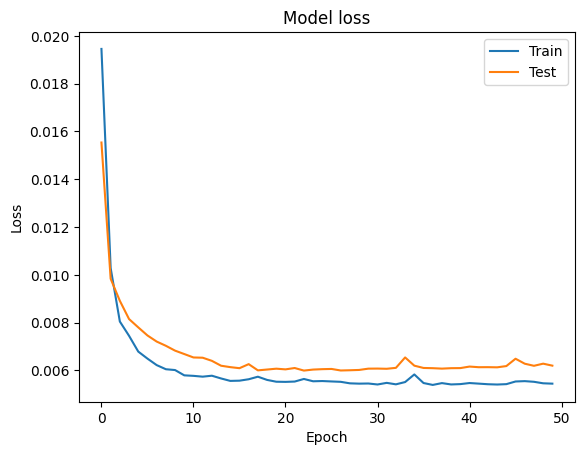

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Expanding Window Cross Validation

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0073 - val_loss: 0.0157
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - val_loss: 0.0123
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - val_loss: 0.0155
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0183
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0179
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0097
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0092
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0130
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - val_loss: 0.0125
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0132
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0135
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0068 - val_loss: 0.0090


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0100 - val_loss: 0.0163
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0190
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0339
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0086 - val_loss: 0.0284
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0076 - val_loss: 0.0182
Epoch 6/50
330/336 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0074 - val_loss: 0.0214
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 30.037989158603494 %
mape test = 37.7341100530726 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0137 - val_loss: 2.3241e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061 - val_loss: 5.1301e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0057 - val_loss: 6.1542e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0057 - val_loss: 6.0997e-04
Epoch 6/50
574/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 5.2512e-04
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 7.039390468430044 %
mape test = 12.490861839247701 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0116 - val_loss: 0.0034
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 9/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 10/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 11/50
820/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0095
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0055 - val_loss: 0.0105
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0056 - val_loss: 0.0128
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0061 - val_loss: 0.0098
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0048 - val_loss: 0.0094
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0065 - val_loss: 0.0110
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 0.0111
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0060 - val_loss: 0.0100
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0057 - val_loss: 0.0096
Epoch 12/50
1058/1065 ━━━━━━━━━━━━━━━━

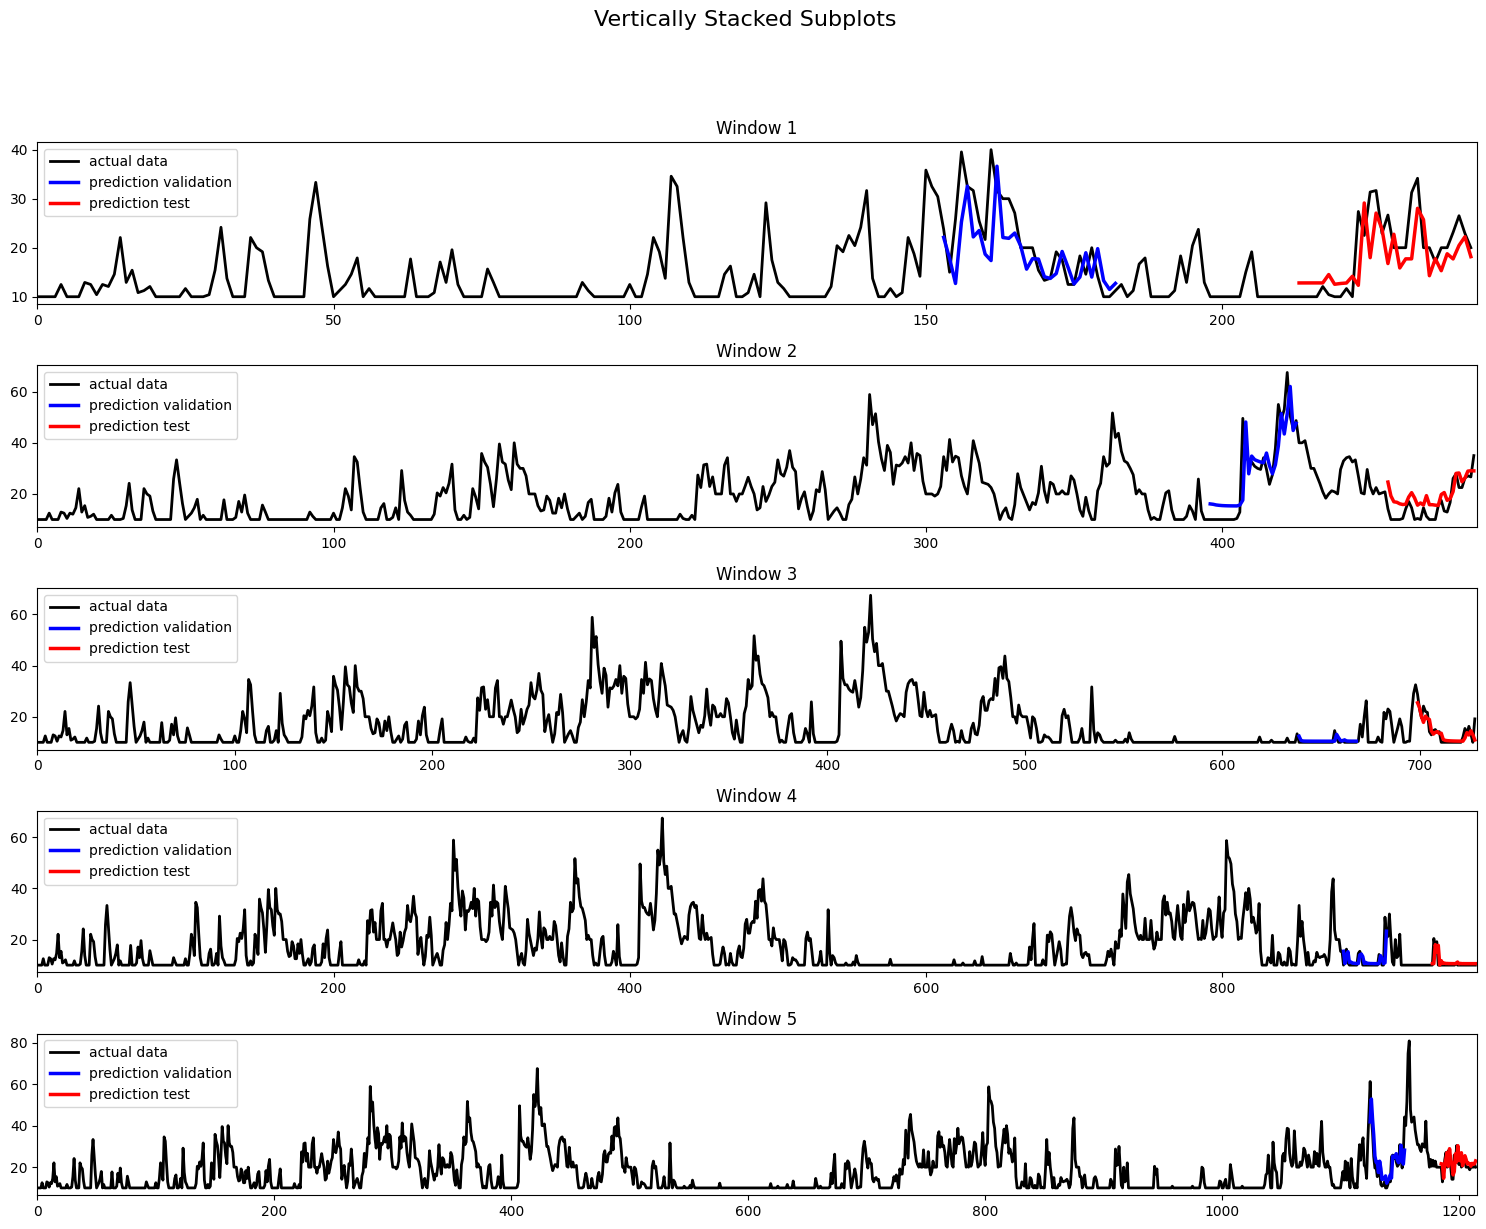


Final Average MAPE Validation: 0.1932
Final Average MAPE Test: 0.2050
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0055 - val_loss: 0.0239
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - val_loss: 0.0123
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0059 - val_loss: 0.0151
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0190
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.0122
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0062 - val_loss: 0.0179
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0114
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0093
Epoch 10/50
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0128
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0122 - val_loss: 0.0296
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0080 - val_loss: 0.0282
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0100 - val_loss: 0.0200
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0216
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0069 - val_loss: 0.0155
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0077 - val_loss: 0.0180
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068 - val_loss: 0.0155
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0081 - val_loss: 0.0225
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - val_loss: 0.0209
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0081 - val_loss: 0.0232
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0076 - val_loss: 0.0232
Epoch 12/50
329/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0123 - val_loss: 8.6680e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 6.1171e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 7.8940e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 2.4992e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 10/50
573/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0056 - val_loss: 2.7537e-04
Epoch 00010: early 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0110 - val_loss: 0.0044
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0070 - val_loss: 0.0030
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 8/50
813/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.18800742311147 %
mape test = 12.991149036460396 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0111
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0067 - val_loss: 0.0102
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0056 - val_loss: 0.0112
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0058 - val_loss: 0.0108
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0062 - val_loss: 0.0098
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0059 - val_loss: 0.0111
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0107
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0059 - val_loss: 0.0091
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0101
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0053 - val_loss: 0.0111
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1742
Final Average MAPE Test: 0.1943
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0058 - val_loss: 0.0341
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0170
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0091
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 0.0218
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0123
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0090
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0085
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0120
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0128
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040 - val_loss: 0.0163
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0146
Epoch 12/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036Restoring model weig

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0141 - val_loss: 0.0165
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0196
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0065 - val_loss: 0.0290
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0058 - val_loss: 0.0214
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0061 - val_loss: 0.0202
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0066 - val_loss: 0.0165
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 0.0235
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0076 - val_loss: 0.0182
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0079 - val_loss: 0.0157
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0079 - val_loss: 0.0301
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 0.0198
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0133 - val_loss: 1.9211e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0100 - val_loss: 5.1725e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081 - val_loss: 3.3426e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0083 - val_loss: 4.5081e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0071 - val_loss: 2.0545e-04
Epoch 6/50
578/579 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 6.240956269654179 %
mape test = 13.144196637635055 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0092 - val_loss: 0.0039
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0061 - val_loss: 0.0041
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0062 - val_loss: 0.0044
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 9/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 10/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 11/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 12/50
814/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0084 - val_loss: 0.0105
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0062 - val_loss: 0.0158
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0063 - val_loss: 0.0106
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0066 - val_loss: 0.0156
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0070 - val_loss: 0.0097
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0070 - val_loss: 0.0117
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0055 - val_loss: 0.0098
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0062 - val_loss: 0.0113
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0060 - val_loss: 0.0116
Epoch 10/50
1060/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 00010

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1571
Final Average MAPE Test: 0.1692
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0079 - val_loss: 0.0174
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - val_loss: 0.0141
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0158
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - val_loss: 0.0107
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0098
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0127
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0098
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0140
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.0131
Epoch 10/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0119
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0117 - val_loss: 0.0167
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0083 - val_loss: 0.0164
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0082 - val_loss: 0.0184
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0062 - val_loss: 0.0270
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0063 - val_loss: 0.0279
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0063 - val_loss: 0.0174
Epoch 7/50
331/336 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0073 - val_loss: 0.0190
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.200545621228173 %
mape test = 23.02095295451893 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0118 - val_loss: 0.0043
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0093 - val_loss: 8.1047e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 2.5785e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0062 - val_loss: 6.8938e-04
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 9/50
573/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064 - val_loss: 6.6500e-04
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0104 - val_loss: 0.0035
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069 - val_loss: 0.0032
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0063 - val_loss: 0.0034
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 9/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 10/50
818/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 00010: early stopping
30/30 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0095 - val_loss: 0.0131
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0064 - val_loss: 0.0099
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0065 - val_loss: 0.0092
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0063 - val_loss: 0.0100
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0069 - val_loss: 0.0114
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0061 - val_loss: 0.0100
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0063 - val_loss: 0.0095
Epoch 8/50
1057/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0059 - val_loss: 0.0112
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 22.401704137176697 %
mape test = 18.03319117913347 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1597
Final Average MAPE Test: 0.1733
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3521 - val_loss: 0.0200
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0381
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.0191
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0081 - val_loss: 0.0168
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0144 - val_loss: 0.0407
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_loss: 0.0132
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.0386
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0066 - val_loss: 0.0142
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - val_loss: 0.0270
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0129
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 0.0078
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - val_loss: 0.0088


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0356 - val_loss: 0.0350
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0085 - val_loss: 0.0179
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0111 - val_loss: 0.0201
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0144 - val_loss: 0.0205
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0112 - val_loss: 0.0365
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0084 - val_loss: 0.0200
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0100 - val_loss: 0.0170
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0082 - val_loss: 0.0349
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0081 - val_loss: 0.0155
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0168
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0087 - val_loss: 0.0174
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0965 - val_loss: 0.0051
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0245 - val_loss: 0.0197
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0164 - val_loss: 6.0215e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0151 - val_loss: 0.0219
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0154 - val_loss: 0.0014
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0161 - val_loss: 0.0189
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.7281 - val_loss: 0.0771
Epoch 8/50
569/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0275 - val_loss: 0.0010
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 15.688200835363562 %
mape test = 17.45838313642933 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1261 - val_loss: 0.0038
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0069 - val_loss: 0.0102
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0082 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0080 - val_loss: 0.0197
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0102 - val_loss: 0.0056
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 9/50
814/822 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 18

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0240 - val_loss: 0.0098
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0078 - val_loss: 0.0094
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0075 - val_loss: 0.0103
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0064 - val_loss: 0.0170
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0096 - val_loss: 0.0154
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 7/50
1059/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0077 - val_loss: 0.0099
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 23.95870051311162 %
mape test = 19.34882005191469 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2238
Final Average MAPE Test: 0.2392
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0184 - val_loss: 0.0171
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - val_loss: 0.0139
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.0099
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0090 - val_loss: 0.0320
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0139
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0230
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057 - val_loss: 0.0076
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0062 - val_loss: 0.0114
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0106
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0147


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0813 - val_loss: 0.0154
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0182
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0110 - val_loss: 0.0272
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0109 - val_loss: 0.0210
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0106 - val_loss: 0.0277
Epoch 6/50
331/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0204
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mape validation = 25.44750735663726 %
mape test = 32.67092406317567 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0422 - val_loss: 0.0019
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0111 - val_loss: 0.0193
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0101 - val_loss: 4.8787e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069 - val_loss: 0.0024
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074 - val_loss: 2.5471e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0083 - val_loss: 0.0015
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0095 - val_loss: 0.0118
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081 - val_loss: 0.0041
Epoch 10/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0077 - val_loss: 4.1829e-04
Epoch 11/50
577/579 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0214 - val_loss: 0.0044
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0090 - val_loss: 0.0075
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0089 - val_loss: 0.0033
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0079 - val_loss: 0.0059
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0082 - val_loss: 0.0093
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 8/50
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 14.22742400619878 %
mape test = 11.426722765941575 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1401 - val_loss: 0.0580
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0337 - val_loss: 0.0254
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0211 - val_loss: 0.0190
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0183 - val_loss: 0.0210
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0208 - val_loss: 0.0112
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0203 - val_loss: 0.0261
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0208 - val_loss: 0.0123
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0184 - val_loss: 0.0110
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0353 - val_loss: 0.0141
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1926
Final Average MAPE Test: 0.2034
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0246 - val_loss: 0.0252
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065 - val_loss: 0.0140
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114 - val_loss: 0.0131
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0127
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 0.0169
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0074 - val_loss: 0.0115
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0063 - val_loss: 0.0129
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0063 - val_loss: 0.0344
Epoch 10/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0151
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0203 - val_loss: 0.0173
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0103 - val_loss: 0.0171
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0106 - val_loss: 0.0362
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0085 - val_loss: 0.0346
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0140 - val_loss: 0.0216
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0089 - val_loss: 0.0279
Epoch 7/50
335/336 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093 - val_loss: 0.0189
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 17.24085323208451 %
mape test = 23.271047979893098 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1193 - val_loss: 0.0310
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0193 - val_loss: 0.0084
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0094 - val_loss: 2.5230e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0092 - val_loss: 9.4876e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0083 - val_loss: 0.0019
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 8/50
572/579 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0079 - val_loss: 3.4435e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 4.5169218505719195 %
mape test = 11.326723509420571 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1072 - val_loss: 0.0165
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0119 - val_loss: 0.0263
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0094 - val_loss: 0.0050
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0117 - val_loss: 0.0036
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0089 - val_loss: 0.0034
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0111 - val_loss: 0.0064
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0092 - val_loss: 0.0034
Epoch 9/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0089 - val_loss: 0.0033
Epoch 10/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0084 - val_loss: 0.0041
Epoch 11/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 12/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0153 - val_loss: 0.0289
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0100 - val_loss: 0.0153
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0080 - val_loss: 0.0164
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0084 - val_loss: 0.0142
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0096 - val_loss: 0.0117
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0087 - val_loss: 0.0103
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0076 - val_loss: 0.0136
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0067 - val_loss: 0.0104
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0067 - val_loss: 0.0095
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0068 - val_loss: 0.0142
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1580
Final Average MAPE Test: 0.1691
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - val_loss: 0.0192
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0249
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0139 - val_loss: 0.0977
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - val_loss: 0.0338
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169 - val_loss: 0.0402
Epoch 6/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0130 - val_loss: 0.0646
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 27.79872486198705 %
mape test = 27.352572799752352 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0224 - val_loss: 0.0319
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - val_loss: 0.0170
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0097 - val_loss: 0.0189
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0121 - val_loss: 0.0203
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0098 - val_loss: 0.0178
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0079 - val_loss: 0.0212
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0114 - val_loss: 0.0164
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0075 - val_loss: 0.0207
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0224
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0100 - val_loss: 0.0218
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0082 - val_loss: 0.0590
Epoch 12/50
333/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0212 - val_loss: 0.0028
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0091 - val_loss: 7.7937e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0081 - val_loss: 0.0017
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0083 - val_loss: 0.0017
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0099 - val_loss: 0.0040
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0098 - val_loss: 0.0019
Epoch 9/50
572/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0103 - val_loss: 0.0012
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0150 - val_loss: 0.0032
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0131 - val_loss: 0.0033
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 6/50
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0094 - val_loss: 0.0032
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 11.92437477051922 %
mape test = 7.995955216603805 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1538 - val_loss: 0.0263
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0073 - val_loss: 0.0125
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0067 - val_loss: 0.0238
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0073 - val_loss: 0.0392
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0078 - val_loss: 0.0110
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0084 - val_loss: 0.0127
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0075 - val_loss: 0.0151
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0074 - val_loss: 0.0190
Epoch 10/50
1059/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0086 - val_loss: 0.0119
Epoch 00010: e

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.2271
Final Average MAPE Test: 0.2279
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0064 - val_loss: 0.0165
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065 - val_loss: 0.0199
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057 - val_loss: 0.0176
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0198
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0167
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0141
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0163
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - val_loss: 0.0125
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0142
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0137
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0130

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0122 - val_loss: 0.0237
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0203
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0074 - val_loss: 0.0217
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0219
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0083 - val_loss: 0.0192
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070 - val_loss: 0.0158
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - val_loss: 0.0181
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - val_loss: 0.0190
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070 - val_loss: 0.0160
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0069 - val_loss: 0.0210
Epoch 11/50
332/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0139 - val_loss: 0.0014
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0083 - val_loss: 8.0379e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0072 - val_loss: 2.3043e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0071 - val_loss: 8.7983e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0063 - val_loss: 2.9154e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0075 - val_loss: 2.0942e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068 - val_loss: 2.7490e-04
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0051 - val_loss: 5.3700e-04
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0051 - val_loss: 5.8921e-04
Epoch 10/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0046 - val_loss: 5.0481e-04
Epoch 11/50
577/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067Restoring model weights from the end of the bes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0126 - val_loss: 0.0031
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 6/50
813/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 15.87167940502638 %
mape test = 10.445853625497973 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0108 - val_loss: 0.0142
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0058 - val_loss: 0.0109
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0065 - val_loss: 0.0098
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0099
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0101
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0052 - val_loss: 0.0120
Epoch 9/50
1057/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0059 - val_loss: 0.0102
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1687
Final Average MAPE Test: 0.1794
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0058 - val_loss: 0.0154
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080 - val_loss: 0.0218
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0179
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0187
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0208
Epoch 6/50
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0163
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 28.719702176246482 %
mape test = 32.649456799948524 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0130 - val_loss: 0.0357
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0093 - val_loss: 0.0260
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070 - val_loss: 0.0178
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073 - val_loss: 0.0215
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0063 - val_loss: 0.0207
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056 - val_loss: 0.0158
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056 - val_loss: 0.0197
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0062 - val_loss: 0.0174
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0056 - val_loss: 0.0177
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0072 - val_loss: 0.0233
Epoch 11/50
334/336 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0125 - val_loss: 0.0016
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0084 - val_loss: 2.8770e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 1.9936e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0058 - val_loss: 4.1496e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068 - val_loss: 3.2489e-04
Epoch 8/50
572/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 2.0755e-04
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 4.235088788195864 %
mape test = 12.42677972121579 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0126 - val_loss: 0.0036
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 9/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 10/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 11/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 12/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0101 - val_loss: 0.0170
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0058 - val_loss: 0.0106
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0049 - val_loss: 0.0097
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0059 - val_loss: 0.0107
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 0.0111
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0047 - val_loss: 0.0100
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 20.23072541415384 %
mape test = 14.550129213713861 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1755
Final Average MAPE Test: 0.1983
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0073 - val_loss: 0.0197
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0129
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0062 - val_loss: 0.0179
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061 - val_loss: 0.0226
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071 - val_loss: 0.0167
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0154
Epoch 7/50
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - val_loss: 0.0207
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 25.04353089349899 %
mape test = 26.795559692818905 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0121 - val_loss: 0.0261
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0224
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0069 - val_loss: 0.0247
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075 - val_loss: 0.0212
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0066 - val_loss: 0.0162
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0059 - val_loss: 0.0164
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0078 - val_loss: 0.0245
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0078 - val_loss: 0.0178
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0063 - val_loss: 0.0162
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0062 - val_loss: 0.0158
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0080 - val_loss: 0.0187
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0151 - val_loss: 6.0756e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0085 - val_loss: 3.4973e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0064 - val_loss: 0.0012
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0065 - val_loss: 3.6430e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061 - val_loss: 5.7674e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0053 - val_loss: 9.0657e-04
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
mape validation = 11.130627751825143 %
mape test = 15.42404791786492 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0113 - val_loss: 0.0031
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 6/50
812/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 15.572449145313255 %
mape test = 9.9664627121826 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0111 - val_loss: 0.0150
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0062 - val_loss: 0.0110
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0058 - val_loss: 0.0099
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0057 - val_loss: 0.0096
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 0.0101
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0057 - val_loss: 0.0097
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0049 - val_loss: 0.0105
Epoch 9/50
1064/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0064 - val_loss: 0.0102
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1806
Final Average MAPE Test: 0.1874
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - val_loss: 0.0281
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0189
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058 - val_loss: 0.0178
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0189
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - val_loss: 0.0172
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0192
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0065 - val_loss: 0.0217
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - val_loss: 0.0178
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0144
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0177
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - val_loss: 0.0175
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0134

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0124 - val_loss: 0.0265
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0090 - val_loss: 0.0190
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0092 - val_loss: 0.0190
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0229
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0072 - val_loss: 0.0158
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0066 - val_loss: 0.0170
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0161
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0061 - val_loss: 0.0174
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0059 - val_loss: 0.0196
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0060 - val_loss: 0.0164
Epoch 00010: early stopping
30/30 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0093 - val_loss: 3.1963e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0065 - val_loss: 3.2754e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060 - val_loss: 6.3729e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068 - val_loss: 5.0700e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0050 - val_loss: 2.3904e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 3.9775e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 7.2696e-04
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0057 - val_loss: 2.1503e-04
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0065 - val_loss: 3.0786e-04
Epoch 10/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0058 - val_loss: 9.0587e-04
Epoch 11/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0051 - val_loss: 2.7902e-04
Epoch 12/50
579/579

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0109 - val_loss: 0.0030
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 6/50
821/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 15.437952550803969 %
mape test = 9.882393419556996 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0085 - val_loss: 0.0136
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0049 - val_loss: 0.0104
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0097
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0061 - val_loss: 0.0101
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 12/50
1065/1065 ━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1654
Final Average MAPE Test: 0.1805
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0068 - val_loss: 0.0183
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 0.0170
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071 - val_loss: 0.0163
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055 - val_loss: 0.0151
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0123
Epoch 7/50
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0121
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 23.055740332615116 %
mape test = 25.244544420798565 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0116 - val_loss: 0.0217
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0082 - val_loss: 0.0287
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0079 - val_loss: 0.0255
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0168
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0076 - val_loss: 0.0162
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0060 - val_loss: 0.0190
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0063 - val_loss: 0.0219
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067 - val_loss: 0.0269
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0085 - val_loss: 0.0156
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0172
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0069 - val_loss: 0.0165
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0098 - val_loss: 2.7218e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0076 - val_loss: 9.9473e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 5.5011e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0076 - val_loss: 6.5230e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0049 - val_loss: 2.5750e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064 - val_loss: 4.1433e-04
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0068 - val_loss: 7.4273e-04
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0056 - val_loss: 5.1568e-04
Epoch 10/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 3.3215e-04
Epoch 11/50
574/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060Restoring model weights from the end of the bes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0100 - val_loss: 0.0031
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 6/50
815/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 12.896313321390771 %
mape test = 6.662052126889802 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0081 - val_loss: 0.0090
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0055 - val_loss: 0.0109
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0055 - val_loss: 0.0105
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0065 - val_loss: 0.0092
Epoch 6/50
1062/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0061 - val_loss: 0.0099
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mape validation = 18.299556122683732 %
mape test = 15.034124536017465 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1590
Final Average MAPE Test: 0.1664
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078 - val_loss: 0.0231
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0093 - val_loss: 0.0198
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0145
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0212
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0129
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0087
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - val_loss: 0.0142
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0111
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0100
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048 - val_loss: 0.0118
Epoch 11/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0098 - val_loss: 0.0247
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0085 - val_loss: 0.0207
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0078 - val_loss: 0.0194
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0060 - val_loss: 0.0169
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0069 - val_loss: 0.0208
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067 - val_loss: 0.0190
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0069 - val_loss: 0.0176
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0073 - val_loss: 0.0171
Epoch 9/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - val_loss: 0.0155
Epoch 10/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - val_loss: 0.0195
Epoch 11/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0060 - val_loss: 0.0223
Epoch 12/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0099 - val_loss: 5.5395e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0069 - val_loss: 8.8758e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064 - val_loss: 6.8694e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0081 - val_loss: 7.6049e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0073 - val_loss: 4.2608e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0059 - val_loss: 2.6871e-04
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0067 - val_loss: 3.0349e-04
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 10/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0074 - val_loss: 0.0010
Epoch 11/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0080 - val_loss: 4.1117e-04
Epoch 12/50
577/579 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0097 - val_loss: 0.0032
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0069 - val_loss: 0.0030
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 9/50
817/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 14

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0068 - val_loss: 0.0122
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0059 - val_loss: 0.0103
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0055 - val_loss: 0.0119
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0056 - val_loss: 0.0097
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0061 - val_loss: 0.0114
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0057 - val_loss: 0.0117
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0055 - val_loss: 0.0104
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0058 - val_loss: 0.0103
Epoch 11/50
1057/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049Restoring model weights from the end of the best epoch.

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1523
Final Average MAPE Test: 0.1649
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0060 - val_loss: 0.0223
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0177
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047 - val_loss: 0.0269
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0121
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0126
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0143
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - val_loss: 0.0148
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0195
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0098
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0091
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0165
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - val_loss: 0.0089


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0111 - val_loss: 0.0163
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0079 - val_loss: 0.0226
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0100 - val_loss: 0.0161
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - val_loss: 0.0230
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0065 - val_loss: 0.0248
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0092 - val_loss: 0.0168
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0061 - val_loss: 0.0201
Epoch 8/50
333/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0071 - val_loss: 0.0188
Epoch 00008: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 18.868107727155962 %
mape test = 25.231941367627826 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0109 - val_loss: 0.0012
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0082 - val_loss: 3.6445e-04
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0067 - val_loss: 2.2581e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0068 - val_loss: 2.8876e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0057 - val_loss: 3.1228e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0051 - val_loss: 4.7990e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060 - val_loss: 2.1831e-04
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066 - val_loss: 0.0013
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 10/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 2.1833e-04
Epoch 11/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0060 - val_loss: 5.8587e-04
Epoch 12/50
575/579 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0097 - val_loss: 0.0038
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0076 - val_loss: 0.0032
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 9/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 10/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 11/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 12/50
819/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0066 - val_loss: 0.0112
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0059 - val_loss: 0.0096
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0057 - val_loss: 0.0095
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0064 - val_loss: 0.0104
Epoch 6/50
1059/1065 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050Restoring model weights from the end of the best epoch.
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 00006: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 20.564438100845802 %
mape test = 16.802856111897643 %


<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1619
Final Average MAPE Test: 0.1766
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0072 - val_loss: 0.0221
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_loss: 0.0138
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061 - val_loss: 0.0213
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0123
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0120
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - val_loss: 0.0142
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060 - val_loss: 0.0134
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0131
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0052 - val_loss: 0.0144
Epoch 10/50
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040Restoring model weights from the end of the best epoch.
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - val_loss: 0.0139
Epoch 00010: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092 - val_loss: 0.0212
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068 - val_loss: 0.0167
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0068 - val_loss: 0.0190
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0059 - val_loss: 0.0203
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0063 - val_loss: 0.0184
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077 - val_loss: 0.0251
Epoch 7/50
329/336 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071Restoring model weights from the end of the best epoch.
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0071 - val_loss: 0.0188
Epoch 00007: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 21.934582905842248 %
mape test = 26.72957252286794 %
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0092 - val_loss: 2.8705e-04
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0063 - val_loss: 6.0010e-04
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0097 - val_loss: 3.2391e-04
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0064 - val_loss: 2.4570e-04
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0064 - val_loss: 9.5105e-04
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0070 - val_loss: 0.0017
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0061 - val_loss: 0.0010
Epoch 10/50
578/579 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061Restoring model weights from the end of the best epoch.
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0061 - val_loss: 6.6614e-04
Epoch 00010: ea

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0094 - val_loss: 0.0031
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 7/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 8/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 9/50
817/822 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059Restoring model weights from the end of the best epoch.
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 00009: early stopping
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
mape validation = 16

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 2/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0056 - val_loss: 0.0109
Epoch 3/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0062 - val_loss: 0.0117
Epoch 4/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0054 - val_loss: 0.0097
Epoch 5/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0060 - val_loss: 0.0101
Epoch 6/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 7/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 8/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0048 - val_loss: 0.0097
Epoch 9/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 10/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0057 - val_loss: 0.0104
Epoch 11/50
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 12/50
1065/1065 ━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>


Final Average MAPE Validation: 0.1722
Final Average MAPE Test: 0.1813


In [26]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, figsize=(15, 12))
fig.suptitle('Vertically Stacked Subplots', fontsize=16, y=1.02)

# Parameter sliding window
window_size = 243        # Train Window
n_test = 60              # Test Window
n_train_and_val = window_size - n_test
n_train = n_train_and_val - 60
shift = 243
n_windows1 = 5
n_total = len(data_series)
look_back = 30
time_step = 30

import itertools

config_params = {
    "learning_rate" : [0.01, 0.05, 0.001, 0.005],
    "batch_size" : [16, 32, 64, 128],
    "neurons" : [50],
}

average_mape_vals_by_param = []
average_mape_tests_by_param = []

for xs in itertools.product(*list(config_params.values())):
  current_param = dict()
  for i, key in enumerate(config_params.keys()):
    if key == "batch_size":
      bsize = xs[i]
    else:
      current_param[key] = xs[i]

  mape_vals = []
  mape_tests = []

  # Simpan nilai asli
  base_n_train = n_train
  base_n_train_and_val = n_train_and_val

  for i in range(n_windows1):
    current_n_train = base_n_train + i * shift
    current_n_train_and_val = base_n_train_and_val + i * shift
    end = current_n_train_and_val + n_test

    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = data_series[:end]  # expanding window
    train_and_val = window_data[:current_n_train_and_val]
    train = train_and_val[:current_n_train]
    val = train_and_val[current_n_train:]
    test = window_data[current_n_train_and_val:]

    try:

          train_generator = TimeseriesGenerator(train, train, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          val_generator = TimeseriesGenerator(val, val, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          test_generator = TimeseriesGenerator(test, test, length = look_back, sampling_rate = 1, stride = 1, batch_size = 1)

          model = create_model(current_param['neurons'], current_param['learning_rate'])

          # model.compile(optimizer='adam', loss='mean_squared_error')

          model.fit(train_generator, epochs=50, validation_data=val_generator, batch_size=bsize, callbacks=[EarlyStoppingAtMinLoss(patience=5)], verbose = 1)

          val_predictions = model.predict(val_generator)
          test_predictions  = model.predict(test_generator)

          val_predictions_descale = scaler.inverse_transform(val_predictions).flatten()
          test_predictions_descale = scaler.inverse_transform(test_predictions).flatten()

          train_actual = scaler.inverse_transform(train).flatten()
          val_actual = scaler.inverse_transform(val).flatten()
          test_actual = scaler.inverse_transform(test).flatten()

          all_actual = np.append(np.append(train_actual, val_actual), test_actual)

          mape_val = mean_absolute_percentage_error(val_actual[-len(val_generator):], val_predictions_descale)
          mape_test = mean_absolute_percentage_error(test_actual[-len(test_generator):], test_predictions_descale)

          mape_vals.append(mape_val)
          mape_tests.append(mape_test)

          print(f"mape validation = {mape_val * 100} %")
          print(f"mape test = {mape_test * 100} %")

          X_actual = np.arange(0, len(train) + len(val) + len(test))
          # X_train = np.arange(0, len(train))
          X_val = np.arange(len(train) + look_back, len(train) + len(val))
          X_test = np.arange(len(train) + len(val) + look_back, len(train) + len(val) + len(test))

          axs[i].plot(X_actual, all_actual, lw=2, color='black', label='actual data')
          axs[i].plot(X_val, val_predictions_descale, lw=2.5, color='blue', label='prediction validation')
          axs[i].plot(X_test, test_predictions_descale, lw=2.5, color='red', label='prediction test')
          axs[i].set_xlim([0, len(all_actual)])
          axs[i].set_title(f'Window {i+1}')
          axs[i].legend(loc='upper left') # legend untuk setiap subplot window

    except Exception as e:
          print(f"Error pada Window {i+1}: {e}")
          continue

  # setelah proses looping selesai
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # agar suptitle tidak ketiban
  plt.show()

  # Rata-rata MAPE akhir
  if mape_vals and mape_tests:
      final_mape_val = np.mean(mape_vals)
      final_mape_test = np.mean(mape_tests)
      print(f"\nFinal Average MAPE Validation: {final_mape_val:.4f}")
      print(f"Final Average MAPE Test: {final_mape_test:.4f}")
      average_mape_vals_by_param.append(final_mape_val)
      average_mape_tests_by_param.append(final_mape_test)

### Hyperparameter Summary (EWCV)

In [28]:
hyperparameter_summary = pd.DataFrame({
    "mape_vals" : average_mape_vals_by_param,
    "mape_tests" : average_mape_tests_by_param
})


hyperparameter_summary.sort_values("mape_tests")

,mape_vals,mape_tests
13,0.152314,0.164862
12,0.158986,0.166364
6,0.157991,0.169113
2,0.157051,0.169214
3,0.159690,0.173344
14,0.161851,0.176622
8,0.168664,0.179419
11,0.165426,0.180520
15,0.172186,0.181270
10,0.180605,0.187365


In [29]:
best_idx = int(hyperparameter_summary.sort_values("mape_tests").index[0])
best_idx

13

In [31]:
parameter_combinations = list(itertools.product(*list(config_params.values())))
best_parameter = parameter_combinations[best_idx]
best_param = dict()
for i, key in enumerate(config_params.keys()):
  best_param[key] = best_parameter[i]
best_param

{'learning_rate': 0.005, 'batch_size': 32, 'neurons': 50}

### Best Parameter (EWCV)

In [32]:
best_param = {'learning_rate': 0.005, 'batch_size': 32, 'neurons': 50}

In [33]:
def create_model(neurons, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [34]:
# Mengambil kolom 'TMA_Daily' sebagai data yang akan diprediksi
time_series_data = data['TMA_Daily'].values.reshape(-1, 1)

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Membagi dataset menjadi data latih dan data uji
train_size = 900
test_size = len(time_series_data) - train_size

train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Fungsi untuk membuat dataset dengan sekuens deret waktu
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
    return np.array(sequences)

# Panjang sekuens deret waktu (jumlah waktu sebelum prediksi)
seq_length = 30 # Time Step

# Membuat dataset dengan sekuens deret waktu
X_train = create_sequences(train_data, seq_length)
X_test = create_sequences(test_data, seq_length)

# Memisahkan fitur dan target
y_train = X_train[:, -1]
X_train = X_train[:, :-1]
y_test = X_test[:, -1]
X_test = X_test[:, :-1]

# Reshaping data untuk LSTM (jumlah sampel, panjang sekuens, jumlah fitur)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = create_model(best_param['neurons'], best_param['learning_rate'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0223 - val_loss: 0.0123
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0067 - val_loss: 0.0078
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0062 - val_loss: 0.0075
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0059 - val_loss: 0.0072
Epoch 13/50


### Plot Model Loss

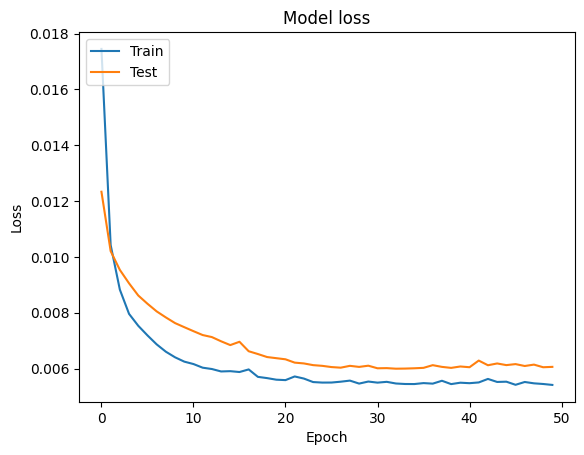

In [35]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()